# Setup (for demo only)
There are helper classes and environment settings that are used here for demo purpose only.
Please use use camera loader and modify the dataset loader for actual use.

In [1]:
%matplotlib inline

import matplotlib
import cv2, lmdb, os
import numpy as np
import msgpack
import msgpack_numpy
from matplotlib import pyplot as plt

plt.style.use("ggplot")
msgpack_numpy.patch()

In [38]:
# Modules from GPA preprocessing repository
import FileIO as fio
import Camera as camsolve

In [3]:
rt_path = "/media/GPA1.0"
meta_path = "/media/GPA1.0/new_meta.mdb"

In [10]:
class MetaReader:
    def __init__(self, path):
        self.db = lmdb.open(path, subdir=False, map_size=1099511627776 * 2, readonly=True,
                            meminit=False, map_async=True)
        
    def get(self, imgid):
        k = u'{:0>10}'.format(imgid).encode('ascii')
        with self.db.begin() as txn:
            with txn.cursor() as cur:
                return msgpack.loads(cur.get(k))
    
    def close(self):
        self.db.close()

In [13]:
meta_io = MetaReader(meta_path)

In [59]:
def param2camproj(params):
    camproj = camsolve.CameraSolverNonlinear()
    camproj.load_params(params)
    return camproj

# Filter (for demo only)
Filter out imgids in training set and samples where subjects are close to the boundary or extend beyond the boundary. Again, the code is for demo purpose only.

In [ ]:
train_id = []
for imgid in range(600000):
    meta = meta_io.get(imgid)
    iid, subj, takename, cam, src_file, dst_file, cam_ts, mocap_ts, sess_date, cam_param_f, markers, joints, geo_name, is_gpa1, is_test = meta
    if is_gpa1 and ~is_test:
        train_id.append(imgid)

In [137]:
edge_id = []
cam_param = {}
for imgid in range(600000):
    meta = meta_io.get(imgid)
    iid, subj, takename, cam, src_file, dst_file, cam_ts, mocap_ts, sess_date, cam_param_f, markers, joints, geo_name, is_gpa1, is_test = meta
    if is_gpa1 and ~is_test:
        train_id.append(imgid)
        if cam_param_f not in cam_param:
            cam_param[cam_param_f] = fio.load_pkl("{:}/{:}".format(rt_path, cam_param_f.decode()))
        camproj = param2camproj(cam_param[cam_param_f]["spatial"])
        imgpts = camproj.project_linear(np.concatenate([markers, joints], axis=0).T)
        # Keep only valid points
        vpts = imgpts[~np.any(np.isnan(imgpts), axis=1)]
        minx, maxx, miny, maxy = np.min(vpts[:, 0]), np.max(vpts[:, 0]), np.min(vpts[:, 1]), np.max(vpts[:, 1])
        if minx <= 5 or miny <= 5 or maxx >= 1915 or maxy >= 1075:
            edge_id.append(imgid)

In [25]:
imgid = train_id[20000]

In [239]:
imgid = edge_id[106]
imgid, subj, takename, camid, src_file, dst_file, cam_ts, mocap_ts, sess_date, cam_param_f, markers, joints, geo_name, is_gpa1, is_test = meta_io.get(imgid)

# Demo for a single example
This section is to demonstrate the process with visualizations.
It's designed with the idea that target_dim, side_pad of output image are adjustable with addition_scaling_ratio for scaling augmentation, if needed.

## Input and Ouput
 - Parameters: output image size (usually 224), padding on each side ( I found 8 is good enough), and additional scaling (<=1.0, only used for scaling augmentation)
 - Input: orginal image, 3D joint points, camera parameters
 - Output: resized, padded, and cropped image, corresponding camera parameters

In [132]:
def aa_resize(img, scaling, interp=cv2.INTER_CUBIC):
    sigma_x, sigma_y = (1 / np.asarray(scaling, dtype=np.float32) - 1) / 2
    imgarr = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma_x, sigmaY=sigma_y)
    return cv2.resize(img, None, fx=scaling[0], fy=scaling[1], interpolation=interp)

In [232]:
img = cv2.imread("{:}/train/{:}".format(rt_path, dst_file.decode()))[:, :, ::-1]
cam = fio.load_pkl("{:}/{:}".format(rt_path, cam_param_f.decode()))

camproj = param2camproj(cam["spatial"])
pts = np.concatenate([markers, joints], axis=0)
imgpts = camproj.project_linear(pts.T)
# Keep only valid points
vpts = imgpts[~np.any(np.isnan(imgpts), axis=1)]
minx, maxx, miny, maxy = np.min(vpts[:, 0]), np.max(vpts[:, 0]), np.min(vpts[:, 1]), np.max(vpts[:, 1])

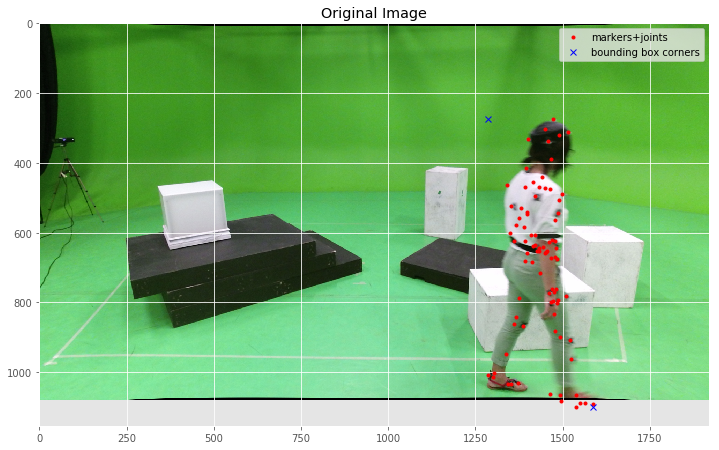

In [233]:
plt.figure(figsize=(12, 10))
plt.title("Original Image")
plt.imshow(img)
plt.plot(imgpts[:, 0], imgpts[:, 1], "r.", label="markers+joints")
plt.plot([minx, maxx], [miny, maxy], "bx", label="bounding box corners")
plt.legend()

In [229]:
target_dim = 224
side_pad = 8
# can only have ratio <= 1.0 
# s.t. image of the person can be smaller but never extend beyond the boundary
# for scaling augmentation
addition_scaling_ratio = 1.0

skel_size = max(maxx - minx, maxy - miny)
is_x_longer = (maxx - minx > maxy - miny)
max_scaling_ratio = float(target_dim - side_pad * 2) / skel_size
scaling = min(addition_scaling_ratio * max_scaling_ratio, max_scaling_ratio)

scaled_img = aa_resize(img, (scaling, scaling))
s_h, s_w, _ = scaled_img.shape

sminx, smaxx, sminy, smaxy = np.array([minx, maxx, miny, maxy]) * scaling
lenx, leny = smaxx - sminx, smaxy - sminy
if is_x_longer:
    sminy -= (target_dim - side_pad - leny) / 2
else:
    sminx -= (target_dim - side_pad - lenx) / 2

bminx, bminy = int(round(sminx - side_pad)), int(round(sminy - side_pad))
top_pad = -min(bminx, 0)
left_pad = -min(bminy, 0)
bmaxx, bmaxy = bminx + target_dim, bminy + target_dim
btn_pad = max(bmaxx - s_w, 0)
right_pad = max(bmaxy - s_h, 0)

optical_center_offset = [bminx, bminy]
bminx, bmaxx = bminx + top_pad, bmaxx + top_pad
bminy, bmaxy = bminy + left_pad, bmaxy + left_pad

r, c, chan = scaled_img.shape
pre_r_pad = np.zeros((left_pad, c, chan), scaled_img.dtype)
post_r_pad = np.zeros((right_pad, c, chan), scaled_img.dtype)
pad_r_img = np.concatenate((pre_r_pad, scaled_img, post_r_pad))

r, c, chan = pad_r_img.shape
pre_c_pad = np.zeros((r, top_pad, chan), scaled_img.dtype)
post_c_pad = np.zeros((r, btn_pad, chan), scaled_img.dtype)
pad_c_img = np.concatenate((pre_c_pad, pad_r_img, post_c_pad), 1)

result image shape (224, 224, 3)


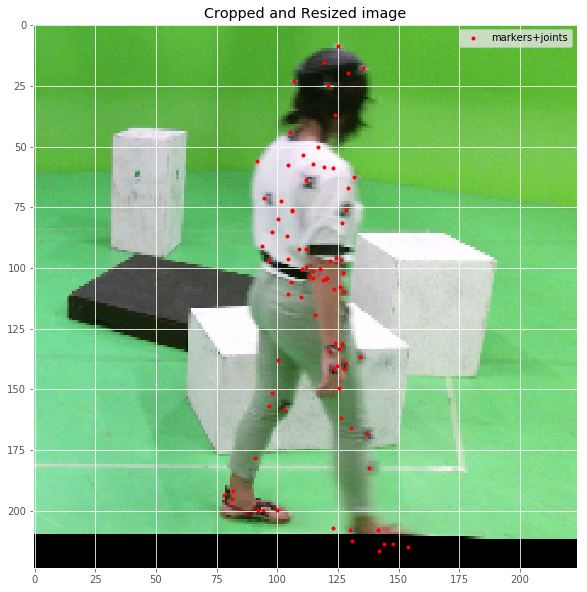

In [235]:
p = cam["spatial"]
e = np.copy(p[0])
e[:2, :] *= scaling
e[:2, 2] -= optical_center_offset
new_params = (e, p[1], p[2], p[3], p[4])
camproj = param2camproj(new_params)
imgpts = camproj.project_linear(pts.T)

plt.figure(figsize=(12, 10))
plt.title("Cropped and Resized image")
plt.imshow(pad_c_img[bminy:bmaxy, bminx:bmaxx, :])
plt.plot(imgpts[:, 0], imgpts[:, 1], "r.", label="markers+joints")
plt.legend()

print("result image shape", pad_c_img[bminy:bmaxy, bminx:bmaxx, :].shape)

# Packed function
The function below is packaged for use in actual training.
This function is supposed to take points on the subject to generate a desired image and a new camera to replicate the transformation in projection.
It's **NOT** supposed to project joints directly to 2D image space.
Please use the new camera parameters for the actual projection and reverse projection in testing time.

## Input and Ouput
 - Parameters: output image size (usually 224), padding on each side ( I found 8 is good enough)
 - Input: orginal image, 3D joint points + marker points (better skeleton outline), camera parameters
 - Output: resized, padded, and cropped image, corresponding camera parameters

In [240]:
# Depend on the Camera Module of GPA preprocess repo, i.e.
import Camera as camsolve

def param2camproj(params):
    camproj = camsolve.CameraSolverNonlinear()
    camproj.load_params(params)
    return camproj

def aa_resize(img, scaling, interp=cv2.INTER_CUBIC):
    sigma_x, sigma_y = (1 / np.asarray(scaling, dtype=np.float32) - 1) / 2
    if sigma_x > 0 and sigma_y > 0:
        imgarr = cv2.GaussianBlur(img, (0, 0), sigmaX=sigma_x, sigmaY=sigma_y)
    else:
        imgarr = img
    return cv2.resize(imgarr, None, fx=scaling[0], fy=scaling[1], interpolation=interp)

def valid_supp_pts(markers, joints):
    pts = np.concatenate([markers, joints], axis=0)
    # Keep only valid points
    vpts = pts[~np.any(np.isnan(pts), axis=1)]
    return vpts

def resize_pad_crop_img_with_camparams(img, world_p, params, target_dim=224, side_pad=8, addition_scaling_ratio = 1.0):
    # Load old camera parameters and project the 3D points
    camproj = param2camproj(params)
    imgpts = camproj.project_linear(world_p.T)
    minx, maxx, miny, maxy = np.min(imgpts[:, 0]), np.max(imgpts[:, 0]), np.min(imgpts[:, 1]), np.max(imgpts[:, 1])
    
    # Decide scaling ratio based on skeleton sizes 
    # Decide the axis to be centered along
    skel_size = max(maxx - minx, maxy - miny)
    is_x_longer = (maxx - minx > maxy - miny)
    max_scaling_ratio = float(target_dim - side_pad * 2) / skel_size
    scaling = min(addition_scaling_ratio * max_scaling_ratio, max_scaling_ratio)

    scaled_img = aa_resize(img, (scaling, scaling))
    s_h, s_w, _ = scaled_img.shape
    
    # Bounding boxes on resized images
    sminx, smaxx, sminy, smaxy = np.array([minx, maxx, miny, maxy]) * scaling
    lenx, leny = smaxx - sminx, smaxy - sminy
    # Center the subject in the cropped area
    if is_x_longer:
        sminy -= (target_dim - side_pad - leny) / 2
    else:
        sminx -= (target_dim - side_pad - lenx) / 2

    # Decide paddings
    bminx, bminy = int(round(sminx - side_pad)), int(round(sminy - side_pad))
    top_pad = -min(bminx, 0)
    left_pad = -min(bminy, 0)
    bmaxx, bmaxy = bminx + target_dim, bminy + target_dim
    btn_pad = max(bmaxx - s_w, 0)
    right_pad = max(bmaxy - s_h, 0)

    # Calculate the new optical center
    # Move the bounding boxes according to paddings
    optical_center_offset = [bminx, bminy]
    bminx, bmaxx = bminx + top_pad, bmaxx + top_pad
    bminy, bmaxy = bminy + left_pad, bmaxy + left_pad

    # Pad the image
    r, c, chan = scaled_img.shape
    pre_r_pad = np.zeros((left_pad, c, chan), scaled_img.dtype)
    post_r_pad = np.zeros((right_pad, c, chan), scaled_img.dtype)
    pad_r_img = np.concatenate((pre_r_pad, scaled_img, post_r_pad))

    r, c, chan = pad_r_img.shape
    pre_c_pad = np.zeros((r, top_pad, chan), scaled_img.dtype)
    post_c_pad = np.zeros((r, btn_pad, chan), scaled_img.dtype)
    pad_c_img = np.concatenate((pre_c_pad, pad_r_img, post_c_pad), 1)
    
    # Scale the focal length according to the scaling factor
    # Offset the optical center accordingly
    e = np.copy(params[0])
    e[:2, :] *= scaling
    e[:2, 2] -= optical_center_offset
    new_params = (e, params[1], params[2], params[3], params[4])
    return pad_c_img[bminy:bmaxy, bminx:bmaxx, :], new_params

## An example of using the function

In [242]:
img = cv2.imread("{:}/train/{:}".format(rt_path, dst_file.decode()))[:, :, ::-1]
cam = fio.load_pkl("{:}/{:}".format(rt_path, cam_param_f.decode()))

w_pts = valid_supp_pts(joints, markers)
r_img, new_cam = resize_pad_crop_img_with_camparams(img, w_pts, cam["spatial"], target_dim=256, side_pad=16, addition_scaling_ratio = 1.0)

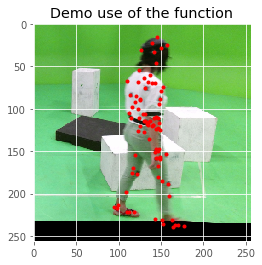

In [244]:
camproj = param2camproj(new_cam)
imgpts = camproj.project_linear(w_pts.T)
plt.title("Demo use of the function")
plt.imshow(r_img)
plt.plot(imgpts[:, 0], imgpts[:, 1], "r.")